In [30]:
import numpy as np
import pandas as pd
from scipy.stats import multivariate_normal
from scipy.stats import distributions as iid
from matplotlib import pyplot as plt

In [42]:
"""DATA GENERATION. Make sure Z and pi are conformable."""

def my_dgp(N, beta, l, pi, var_u, var_v, cov_uv):
    uv_dist = multivariate_normal(cov=[[var_u, cov_uv], [cov_uv, var_v]]) # this allows u and v to be correlated
    uv_data = uv_dist.rvs(N)
    u = uv_data[:, 0]
    v = uv_data[:, 1]
    Z = iid.norm().rvs(N) # initialize our Z matrix as Nx1. Note z is independent of u and v.
    for _ in range(l-1):
        Z = np.column_stack((Z, iid.norm().rvs(N))) # If we want multiple instruments, add columns to Z
    if l == 1:
        X = Z*pi + v
    else:
        pi = pi*np.ones(l)
        X = Z@pi + v
    y = X*beta + u # Since X and u are correlated, OLS should be bad.

    return y,np.column_stack((np.ones(N), X)),np.column_stack((np.ones(N), Z))

In [32]:
"""This function returns my estimates of beta using HFUL, linear IV, and OLS."""
def HFUL_LinIV_OLS(N, dgp):
    # Generate data
    y,X,Z = dgp(N)
    n = y.shape[0]
    k = X.shape[1]
    # Prep some matrices
    P = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    X_bar = np.column_stack((y, X))
    # Calculate alpha hat
    PXbarXbar = np.zeros((X_bar.shape[1], X_bar.shape[1]))
    for i in range(n):
        PXbarXbar = PXbarXbar + P[i, i] * np.outer(X_bar[i, :], X_bar[i, :])
    A = np.linalg.inv(X_bar.T @ X_bar) @ (X_bar.T @ P @ X_bar - PXbarXbar)
    w, v = np.linalg.eig(A)
    alpha_tilde = np.amin(w)
    alpha_hat = ((n+1) * alpha_tilde - 1)/(n + alpha_tilde - 1)
    # Now calculate b HFUL
    PXX = np.zeros((X.shape[1], X.shape[1]))
    PXy = np.zeros(k)
    for i in range(n):
        PXX = PXX + P[i, i] * np.outer(X[i, :], X[i, :])
    for i in range(n):
        PXy = PXy + P[i, i] * X[i, :] * y[i]
    b_hful_term1 = X.T @ P @ X - PXX - alpha_hat * X.T @ X
    b_hful_term2 = X.T @ P @ y - PXy - alpha_hat * X.T @ y
    b_hful = np.linalg.inv(b_hful_term1) @ b_hful_term2
    # Now calculate linear IV estimate
    Pz = Z @ np.linalg.inv(Z.T @ Z) @ Z.T
    b_liniv = np.linalg.inv(X.T @ Pz @ X) @ X.T @ Pz @ y
    # Finally, the good ol OLS estimates
    b_ols = np.linalg.inv(X.T @ X) @ X.T @ y
    # Put them all together and return.
    return np.array([b_hful[1], b_liniv[1], b_ols[1]])

# Just Identified

In [33]:
N = 1000 # bigger sample sizes take 4ever
beta = 1
l = 1 # just identified
pi = 0.05 # fairly weak instrument
var_u = 1
var_v = 1
cov_uv = 0.2
""" I apologize for using the lambda function. My code was taking forever, so I used lambda with the
    hope that it came with some gain in efficiency. I don't think it did, but it is confusing."""
B_hful_iv_ols = pd.DataFrame(
    [HFUL_LinIV_OLS(N, lambda N: my_dgp(N, beta, l, pi, var_u, var_v, cov_uv)) for i in range(1000)])

In [35]:
B_hful = B_hful_iv_ols.iloc[:, 0]
B_liniv = B_hful_iv_ols.iloc[:, 1]
B_ols = B_hful_iv_ols.iloc[:, 2]

# Histogram for OLS
It's biased.

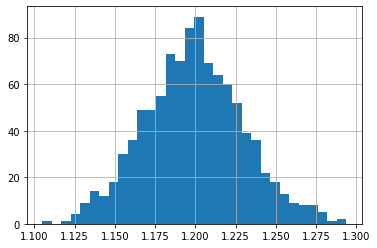

In [40]:
B_ols.hist(bins=int(np.ceil(np.sqrt(B_ols.shape[0]))))

# Histogram for Linear IV
Fat tails.

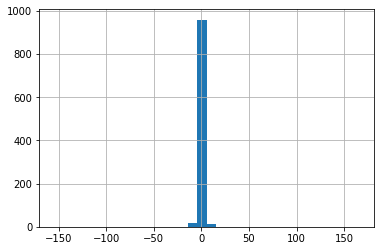

In [37]:
B_liniv.hist(bins=int(np.ceil(np.sqrt(B_liniv.shape[0]))))

# Histogram for HFUL
Beautiful.

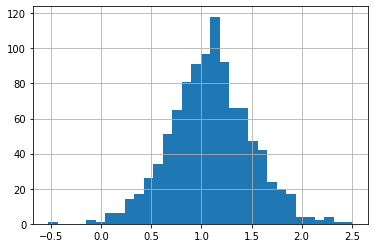

In [39]:
B_hful.hist(bins=int(np.ceil(np.sqrt(B_hful.shape[0]))))

# Over-identified
Let's compare HFUL to linear IV when we have lots of instruments. We'll have 50 instruments.

In [46]:
N = 1000 # bigger sample sizes take forever
beta = 1
l = 50 # just identified
pi = 0.05 # fairly weak instrument
var_u = 1
var_v = 1
cov_uv = 0.2
""" I apologize for using the lambda function. My code was taking forever, so I used lambda with the
    hope that it came with some gain in efficiency. I don't think it did, but it is confusing."""
B_hful_iv_ols = pd.DataFrame(
    [HFUL_LinIV_OLS(N, lambda N: my_dgp(N, beta, l, pi, var_u, var_v, cov_uv)) for i in range(1000)])

In [47]:
B_hful = B_hful_iv_ols.iloc[:, 0]
B_liniv = B_hful_iv_ols.iloc[:, 1]

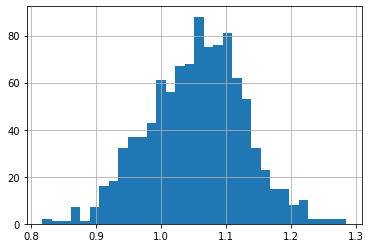

In [48]:
B_liniv.hist(bins=int(np.ceil(np.sqrt(B_liniv.shape[0]))))

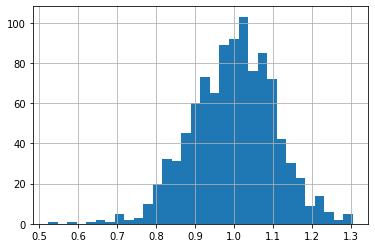

In [49]:
B_hful.hist(bins=int(np.ceil(np.sqrt(B_hful.shape[0]))))

# Many weak(er) instruments
Change $\pi$ to 0.01.

In [50]:
N = 1000 # bigger sample sizes take forever
beta = 1
l = 50 # just identified
pi = 0.01 # fairly weak instrument
var_u = 1
var_v = 1
cov_uv = 0.2
""" I apologize for using the lambda function. My code was taking forever, so I used lambda with the
    hope that it came with some gain in efficiency. I don't think it did, but it is confusing."""
B_hful_iv_ols = pd.DataFrame(
    [HFUL_LinIV_OLS(N, lambda N: my_dgp(N, beta, l, pi, var_u, var_v, cov_uv)) for i in range(1000)])

In [51]:
B_hful = B_hful_iv_ols.iloc[:, 0]
B_liniv = B_hful_iv_ols.iloc[:, 1]

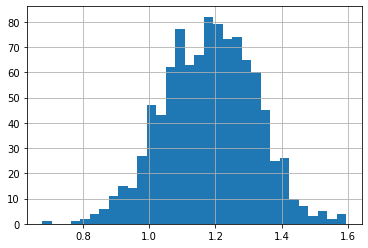

In [52]:
B_liniv.hist(bins=int(np.ceil(np.sqrt(B_liniv.shape[0]))))

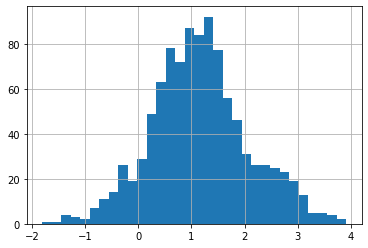

In [53]:
B_hful.hist(bins=int(np.ceil(np.sqrt(B_hful.shape[0]))))

# Old code that I should delete.

In [ ]:
""" OLD DGP
I know this part has problems. The covariance matrix must be positive definite. I don't want to have to specify every
term of the covariance matrix, so I just let it be a random pos def matrix (using make_spd_matrix). But then I changed 
some of the terms to make sure that my z variables are uncorrelated with the error term u. After doing this, the matrix
is only sometimes positive definite. When an error pops up, I just keep retrying until I get lucky and it's still
positive definite.

# Generate data, use random draws from multivariate normal
n = 10000
k = 3
l = 50
dim_cov_matrix = k + l + 1
cov_matrix = make_spd_matrix(dim_cov_matrix) # initialize covariance matrix as random
for i in range(k, l):
    cov_matrix[i, (k+l)] = 0 # make sure exclusion restriction holds
    cov_matrix[(k+l), i] = 0
data_dist = multivariate_normal(cov=cov_matrix)
data = data_dist.rvs(n)
X = data[:, range(0, k)]
Z = data[:, range(k, l)]
u = data[:, k+l]
"""